In [1]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt;
import nltk;
from nltk.sentiment.vader import SentimentIntensityAnalyzer;
sia = SentimentIntensityAnalyzer();

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Read Dataframe

In [12]:
data = '/kaggle/input/sentiment-analysis-test/cleaned_data.csv'
cols = ['rating', 'comment', 'day', 'year', 'month', 'combined_date', 'day_of_week']
df = pd.read_csv(data, usecols=cols)
df.head()

,rating,comment,day,year,month,combined_date,day_of_week
0,4.0,Updates are regular and accuracy/consistency i...,21,2023,12,2023-12-21,Sunday
1,NaN,This is a useless piece of software. Every ti...,22,2023,12,2023-12-22,Monday
2,NaN,Getting rid of that subscription or even delet...,20,2023,12,2023-12-20,Saturday
3,1.0,I've had the Quicker Starter for quite sometim...,12,2023,12,2023-12-12,Friday
4,3.0,I was much happier with Quicken when it was ow...,1,2023,1,2023-01-01,Monday


In [20]:
print('df shape \n',df.shape, '\n\n', 'misisng value count')
df.isna().sum().rename("Missing_Values_Count")


df shape 
 (6620, 7) 

 misisng value count


rating           196
comment          598
day                0
year               0
month              0
combined_date      0
day_of_week        0
Name: Missing_Values_Count, dtype: int64

### SENTIMENT SCORE FUNCTION WITH VADER'S SENTIMENT ANALYZER

In [22]:
def get_sentiment_score(text):
    if pd.isnull(text) or not text.strip():
        return 0.0  # Return a neutral score for null or empty rows
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    return scores['compound']

### GET SENTIMENT SCORE AND SENTIMENT -- NEGATIVE OR POSITIVE

In [23]:
df['sentiment_score'] = df['comment'].apply(get_sentiment_score)
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral'))

In [28]:
df['sentiment'].value_counts().rename('count')

sentiment
Positive    3530
Negative    1665
Neutral     1425
Name: count, dtype: int64

In [29]:
unique_count = df['sentiment_score'].round(2).nunique()
print('Distinct sentiment scores:',unique_count)

Distinct sentiment scores: 198


In [56]:
percentages = (df.groupby('sentiment').size() / len(df['sentiment']) * 100).round(2).sort_values(ascending=False)
percentages

sentiment
Positive    53.32
Negative    25.15
Neutral     21.53
dtype: float64

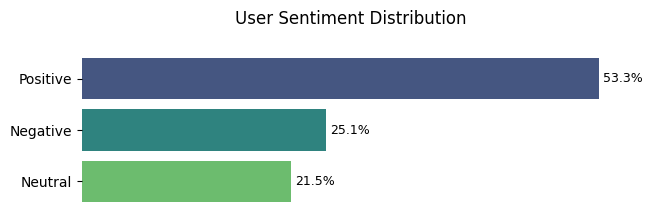

In [95]:
plt.figure(figsize=(7, 2))
sentiment_order = percentages.index
ax = sns.barplot(x=percentages, y=percentages.index, order= sentiment_order, palette='viridis')
sns.despine(left=True, bottom=True, right=True, top=True)
ax.get_xaxis().set_visible(False)
ax.set_ylabel('')
plt.title('User Sentiment Distribution \n')

for p, percentage in zip(ax.patches, percentages):
    x = p.get_width() + 2.5
    y = p.get_y() + p.get_height() / 2
    ax.annotate(f'{percentage:.1f}%', (x, y), ha='center', va='center', color='black', fontsize=9)

plt.show()


### IMPLEMENT SPACY AND REMOVE STOP WORDS

In [45]:
import spacy

# Load the English model
nlp = spacy.load("en_core_web_sm")

def remove_stop_words(comment):
    if pd.isnull(comment):
        return ''  # Return an empty string for NaN values
    doc = nlp(comment)
    no_stop_words = " ".join([token.text for token in doc if not token.is_stop])
    return no_stop_words

df['no_stop_words'] = df['comment'].apply(remove_stop_words)
df.head()

,rating,comment,day,year,month,combined_date,day_of_week,sentiment_score,sentiment,no_stop_words
0,4.0,Updates are regular and accuracy/consistency i...,21,2023,12,2023-12-21,Sunday,0.0000,Neutral,Updates regular accuracy / consistency present...
1,NaN,This is a useless piece of software. Every ti...,22,2023,12,2023-12-22,Monday,-0.3818,Negative,useless piece software . time download accou...
2,NaN,Getting rid of that subscription or even delet...,20,2023,12,2023-12-20,Saturday,-0.4588,Negative,Getting rid subscription deleting account impo...
3,1.0,I've had the Quicker Starter for quite sometim...,12,2023,12,2023-12-12,Friday,-0.7825,Negative,Quicker Starter accountant hates Profit Loss s...
4,3.0,I was much happier with Quicken when it was ow...,1,2023,1,2023-01-01,Monday,0.9042,Positive,happier Quicken owned Intuit . renew year ( ti...


### SEPARATE DATAFRAME FOR NEGATIVE SENTIMENT RECORDS

In [46]:
df_neg = df[df['sentiment'] == 'Negative']
df_neg.head()

,rating,comment,day,year,month,combined_date,day_of_week,sentiment_score,sentiment,no_stop_words
1,NaN,This is a useless piece of software. Every ti...,22,2023,12,2023-12-22,Monday,-0.3818,Negative,useless piece software . time download accou...
2,NaN,Getting rid of that subscription or even delet...,20,2023,12,2023-12-20,Saturday,-0.4588,Negative,Getting rid subscription deleting account impo...
3,1.0,I've had the Quicker Starter for quite sometim...,12,2023,12,2023-12-12,Friday,-0.7825,Negative,Quicker Starter accountant hates Profit Loss s...
13,4.0,don't use it much. Need a way to not give pass...,1,2023,9,2023-09-01,Monday,-0.6390,Negative,use . Need way password time . Program remem...
17,3.0,It is very very different from QuickBooks. I ...,5,2023,9,2023-09-05,Friday,-0.9027,Negative,different QuickBooks . QuickBooks user 15 ye...


In [96]:
df_neg.to_csv('negative_sentiment.csv',index= False)
df_neg.loc[59, 'no_stop_words']

'piece garbage . spend hours getting things set , connect accounts , spend literally 10 minutes opening tries unsuccessfully connect accounts . worst pieces trash charged . small business , use software . found waste time money , frustrating lacks ability going . tried multiple times , months ... tried waiting , tried updating . , works . hey , added cute charts showing incorrect data ! Woot ! sure understand selling . Seriously disappointed , apparent , horrendously - rated . Truly disgusted performance . unbelievable bad software .'